<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

'Assignment2 (1).ipynb'       Image_classification_data.zip
 Assignment2.ipynb	      patch_images
 Assignment2_s3714805.ipynb   Untitled0.ipynb
 CMLAssignment2-main.zip      Untitled2.ipynb
 data_labels_extraData.csv   'Untitled8 (1).ipynb'
 data_labels_mainData.csv     Untitled8.ipynb


In [9]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data.zip' .
!unzip -q -o 'Image_classification_data.zip'
!rm 'Image_classification_data.zip'
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [13]:
data = pd.read_csv('./data_labels_mainData.csv')
OUTPUT_CLASSES = 4
data.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

# New Section

In [6]:
data.groupby('cellTypeName').agg('count')

,InstanceID,patientID,ImageName,cellType,isCancerous
cellTypeName,,,,,
epithelial,4079,4079,4079,4079,4079
fibroblast,1888,1888,1888,1888,1888
inflammatory,2543,2543,2543,2543,2543
others,1386,1386,1386,1386,1386


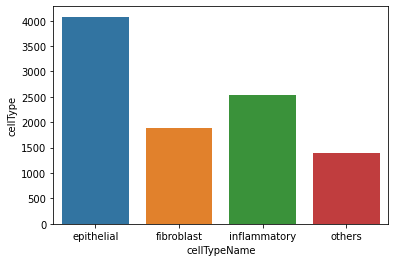

In [7]:
sns.barplot(x=data.groupby('cellTypeName').agg('count').index, 
            y='cellType', 
            data=data.groupby('cellTypeName').agg('count'))

In [8]:
data.groupby('isCancerous').agg('count')

,InstanceID,patientID,ImageName,cellTypeName,cellType
isCancerous,,,,,
0,5817,5817,5817,5817,5817
1,4079,4079,4079,4079,4079


In [ ]:
sns.barplot(x=mergeData.groupby('isCancerous').agg('count').index, 
            y='cellType', 
            data=data.groupby('isCancerous').agg('count'))

In [10]:
data.groupby(['cellTypeName', 'isCancerous']).agg('count')

,,InstanceID,patientID,ImageName,cellType
cellTypeName,isCancerous,,,,
epithelial,1,4079,4079,4079,4079
fibroblast,0,1888,1888,1888,1888
inflammatory,0,2543,2543,2543,2543
others,0,1386,1386,1386,1386


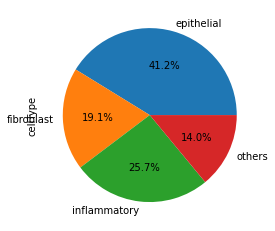

In [11]:
data.groupby('cellTypeName').agg('count').cellType.plot.pie(autopct="%.1f%%")

In [11]:
extraData = pd.read_csv('data_labels_extraData.csv')
extraData.columns

Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')

In [14]:
mergedData = pd.concat([data[["InstanceID", "patientID", "ImageName", "isCancerous"]], extraData])

In [15]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [21]:
train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [72]:

reg_lambda = 0.0001
modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [16]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.show()

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [43]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])


In [ ]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks= [early_stopping], epochs=50)

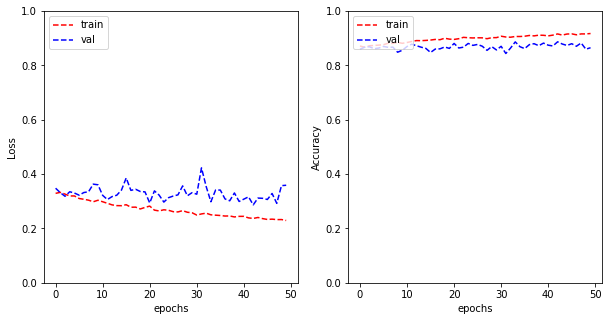

In [37]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [18]:
reg_lambda = 0.00001

modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [19]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.00001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [22]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks=[early_stopping], epochs=50)

Epoch 1/50
451/451 [==============================] - 78s 170ms/step - loss: 0.6355 - categorical_accuracy: 0.6510 - val_loss: 0.6133 - val_categorical_accuracy: 0.6573
Epoch 2/50
451/451 [==============================] - 76s 169ms/step - loss: 0.5720 - categorical_accuracy: 0.7083 - val_loss: 0.5539 - val_categorical_accuracy: 0.7014
Epoch 3/50
451/451 [==============================] - 77s 170ms/step - loss: 0.5074 - categorical_accuracy: 0.7684 - val_loss: 0.5182 - val_categorical_accuracy: 0.7394
Epoch 4/50
451/451 [==============================] - 76s 168ms/step - loss: 0.4707 - categorical_accuracy: 0.7867 - val_loss: 0.5178 - val_categorical_accuracy: 0.7396
Epoch 5/50
451/451 [==============================] - 76s 169ms/step - loss: 0.4531 - categorical_accuracy: 0.7959 - val_loss: 0.4339 - val_categorical_accuracy: 0.7894
Epoch 6/50
451/451 [==============================] - 76s 169ms/step - loss: 0.4357 - categorical_accuracy: 0.8010 - val_loss: 0.4758 - val_categorical_acc

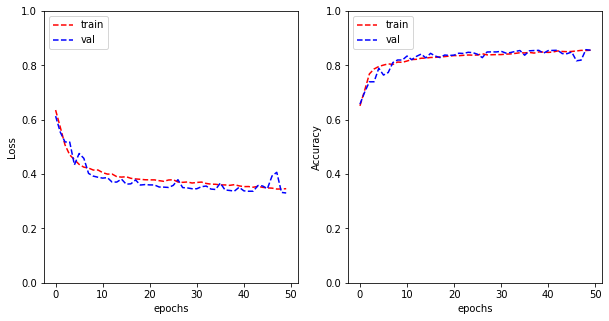

In [23]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

In [24]:
modelCancerous.save("modelCancerous")
!cp -R ./modelCancerous/content/drive/'Colab Notebooks'

INFO:tensorflow:Assets written to: modelCancerous/assets
cp: missing destination file operand after './modelCancerous/content/drive/Colab Notebooks'
Try 'cp --help' for more information.


In [48]:
modelCancerous.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 27)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 54)        13176     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 54)        26298     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 54)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 108)         5

In [46]:
modelCancerous.pop()

In [ ]:
modelCancerous.summary()

In [47]:
modelCancerous.add(Dense(4, activation='softmax'))

In [49]:
from tensorflow import keras
modelCelltype = keras.models.load_model('/content/modelCancerous')

In [74]:
modelCelltype = modelCancerous

In [75]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [76]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
     
     
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
modelCelltype.summary()

In [77]:
modelCelltype.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_sparse_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [66]:
class_weight = {0: 1.,1: 2.,2: 2., 3: 1.}

In [ ]:
class_weights={"class_1": 1, "class_2": 10}

In [ ]:
historyCancerous = modelCelltype.fit(train_generator, validation_data = validation_generator, callbacks=[early_stopping], epochs=50)

Epoch 1/50
220/220 [==============================] - 37s 167ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8745 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.7408
Epoch 2/50
  5/220 [..............................] - ETA: 34s - loss: 0.3131 - sparse_categorical_accuracy: 0.8741

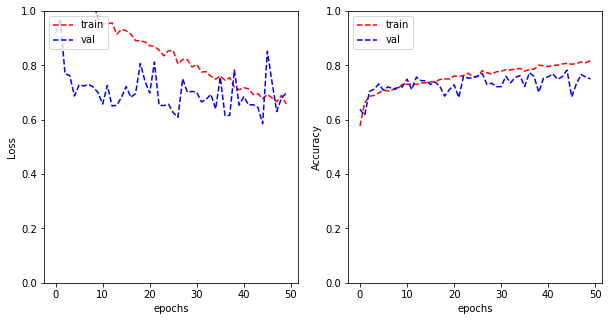

In [68]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['sparse_categorical_accuracy'], historyCancerous.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
test_data['Class'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.7283


[1.578864574432373, 0.7282828092575073]

In [ ]:
model_VGG_3.optimizer.get_config()

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9137693078479194
F1 score:  0.9092785580010481
[[30050  1201]
 [ 3360 18282]]
